In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

import xarray as xr
import numpy as np
import xrpgen
import pandas as pd
import dask.array as da
import itertools
import submitit
import sys
import json

sys.path.append("/u/project/pasaniuc/kangchen/2021-admix-corr")
import admix_genet_cor

In [21]:
dset = xr.open_zarr("OLD_out/dataset/n_indiv_20000_anc_prop_0.2.zarr/")
dset = xr.Dataset(
    data_vars={
        "geno": (("snp", "indiv", "ploidy"), dset.geno.data.swapaxes(0, 1)),
        "lanc": (("snp", "indiv", "ploidy"), dset.lanc.data.swapaxes(0, 1)),
    },
    attrs={"n_anc": 2},
)

In [20]:
def submit_simulate_pheno(var_g: float, pcausal: float, gamma: float, out_prefix: str):
    np.random.seed(1234)
    import sys

    sys.path.append("/u/project/pasaniuc/kangchen/2021-admix-corr")
    import admix_genet_cor

    sim = admix_genet_cor.simulate_continuous_pheno(
        dset,
        var_g=var_g,
        gamma=gamma,
        var_e=1.0,
        n_causal=int(dset.dims["snp"] * pcausal),
        n_sim=30,
    )
    np.save(out_prefix + ".beta.npy", sim["beta"])
    sim["pheno"].to_csv(out_prefix + ".pheno.tsv", index=True, sep="\t")


submit_simulate_pheno(1.0, 1.0, 1.0, "tmp")

admix_genet_cor.simulate_continuous_pheno: 100%|██████████| 1/1 [00:10<00:00, 10.75s/it]


In [23]:
def submit_compute_grm(out_prefix: str):

    import sys

    sys.path.append("/u/project/pasaniuc/kangchen/2021-admix-corr")
    import admix_genet_cor

    K1, K2, K12 = admix_genet_cor.compute_grm(dset, center=True)

    np.save(out_prefix + ".K1.npy", K1)
    np.save(out_prefix + ".K2.npy", K2)
    np.save(out_prefix + ".K12.npy", K12)


executor = submitit.SgeExecutor(folder="./submitit-logs")

executor.update_parameters(
    time_min=120,
    memory_g=60,
    setup=[
        "export PATH=~/project-pasaniuc/software/miniconda3/bin:$PATH",
        "export PYTHONNOUSERSITE=True",
    ],
)

jobs = executor.map_array(submit_compute_grm, ["tmp"])

In [30]:
def submit_estimate(out_prefix: str):

    import sys

    sys.path.append("/u/project/pasaniuc/kangchen/2021-admix-corr")
    import admix_genet_cor

    # Step 1: load GRM
    K1 = np.load("tmp.K1.npy")
    K2 = np.load("tmp.K2.npy")
    K12 = np.load("tmp.K12.npy")

    dset["A1"] = (("indiv", "indiv"), K1 + K2)
    dset["A2"] = (("indiv", "indiv"), K12 + K12.T)

    # K1, K2, K12 are no longer used, release memory for them
    del K1, K2, K12

    # Step 2: load phenotype and estimate
    pheno = pd.read_csv("tmp.pheno.tsv", delim_whitespace=True, index_col=0)
    print(pheno.head())

    rls_list = admix_genet_cor.estimate_genetic_cor(dset, pheno.values)

    data = [
        {"estimate": rls[0].tolist(), "varcov": rls[1].tolist()} for rls in rls_list
    ]

    with open(out_prefix + ".estimate.json", "w") as out:
        json.dump(data, out)


executor = submitit.SgeExecutor(folder="./submitit-logs")

executor.update_parameters(
    time_min=180,
    memory_g=60,
    setup=[
        "export PATH=~/project-pasaniuc/software/miniconda3/bin:$PATH",
        "export PYTHONNOUSERSITE=True",
    ],
)

jobs = executor.map_array(submit_estimate, ["tmp"])

In [32]:
with open(f"tmp.estimate.json") as f:
    data = json.load(f)

In [33]:
df_tmp = pd.DataFrame(
    np.array([d["estimate"] for d in data]), columns=["var_g", "gamma", "var_e"]
)

In [38]:
df_tmp.mean(axis=0)

var_g    1.003195
gamma    1.001010
var_e    0.997398
dtype: float64

In [40]:
import admix

In [42]:
admix_genet_cor.af_per_anc(dset)

In [47]:
import matplotlib.pyplot as plt

(array([204., 201., 180., 209., 193., 204., 198., 218., 215., 178.]),
 array([0.04744434, 0.09295319, 0.13846204, 0.18397089, 0.22947974,
        0.27498859, 0.32049744, 0.36600629, 0.41151513, 0.45702398,
        0.50253283]),
 <BarContainer object of 10 artists>)

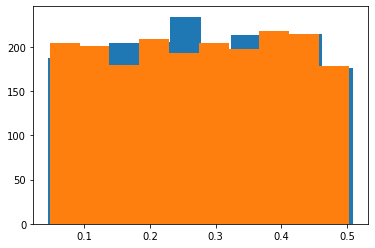

In [50]:
plt.hist(dset["af_per_anc"].values[:, 0])
plt.hist(dset["af_per_anc"].values[:, 1])

(array([204., 201., 180., 209., 193., 204., 198., 218., 215., 178.]),
 array([0.04744434, 0.09295319, 0.13846204, 0.18397089, 0.22947974,
        0.27498859, 0.32049744, 0.36600629, 0.41151513, 0.45702398,
        0.50253283]),
 <BarContainer object of 10 artists>)

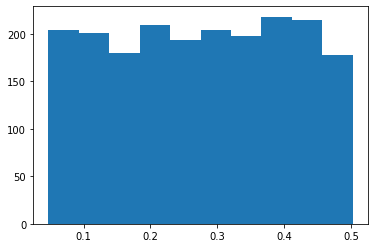

In [49]:
plt.hist(dset["af_per_anc"].values[:, 1])